
# Project Nova — Equitable Credit Scoring Engine (Notebook)

This notebook demonstrates an **end-to-end pipeline** for the Nova Score:
- Load data (uses your existing CSV or falls back to a synthetic generator)
- Feature engineering
- Model training (XGBoost regressor)
- Evaluation
- Explainability (SHAP)
- Fairness analysis (group errors + demographic parity on approvals)
- Bias mitigation (Fairlearn ThresholdOptimizer)
- Actionable improvement tips

> 

In [20]:

import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from xgboost import XGBRegressor

import shap
import matplotlib.pyplot as plt

from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference
from fairlearn.postprocessing import ThresholdOptimizer
from sklearn.linear_model import LogisticRegression

# Plotting defaults (no custom styles/colors as requested)
plt.rcParams.update({"figure.figsize": (7,4)})

pd.set_option("display.max_columns", 100)


In [21]:

# === Configure your data path here ===
DATA_PATH = Path(r"D:\lifescore\data\lifescore_data.csv")  # Change if needed

# Fallback synthetic data (already created alongside this notebook)
FALLBACK_CSV = Path(r"/mnt/data/nova_synthetic_data.csv")

def load_or_fallback(path: Path, fallback: Path) -> pd.DataFrame:
    if path.exists():
        print(f"✅ Loaded existing CSV: {path}")
        df = pd.read_csv(path)
    else:
        print(f"⚠️ Existing CSV not found at {path}. Using fallback synthetic data: {fallback}")
        df = pd.read_csv(fallback)
    return df

df = load_or_fallback(DATA_PATH, FALLBACK_CSV)
print(df.shape)
df.head()


✅ Loaded existing CSV: D:\lifescore\data\lifescore_data.csv
(2000, 12)


,user_id,total_jobs,on_time_deliveries,cancelled_jobs,income_volatility,repeat_customers,peer_ratings,jobs_last_6m,jobs_last_12m,transaction_volume,customer_feedback_score,lifescore
0,1,122,207,27,0.762303,11,4.56,121,258,94321,2,610.884251
1,2,455,451,37,0.038938,17,4.64,231,446,69078,6,593.162631
2,3,368,477,30,0.837120,65,3.54,110,210,83598,4,558.588392
3,4,290,87,26,0.619526,73,2.72,151,68,71902,9,300.031405
4,5,126,413,4,0.563395,78,3.59,204,384,27465,2,1000.000000


In [22]:

# If your CSV doesn't have `nova_score`, create a synthetic target from available columns
def ensure_nova_score(df: pd.DataFrame) -> pd.DataFrame:
    if "nova_score" in df.columns:
        return df
    
    # Try to map generic LifeScore columns to Nova-style features; otherwise compute from basics
    cols = df.columns
    # Best-effort derivations if present
    if set(["on_time_deliveries","total_jobs","income_volatility","repeat_customers","peer_ratings",
            "jobs_last_6m","jobs_last_12m","customer_feedback_score"]).issubset(cols):
        reliability = (df["on_time_deliveries"]/(df["total_jobs"]+1)).clip(0,1)
        trust = (df["repeat_customers"]/df["repeat_customers"].max().clip(1)).fillna(0)*0.7 + (df["peer_ratings"]/5)*0.3
        behavior = (df["jobs_last_6m"]/(df["jobs_last_12m"]+1)).clip(0,1)
        base = (
            reliability*300 + trust*220 + behavior*150 + (df["customer_feedback_score"]/10)*100 - df["income_volatility"]*150
        )
        noise = np.random.normal(0, 25, len(df))
        df["nova_score"] = (base + noise).clip(0, 1000)
    else:
        # Minimal synthetic score
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        base = df[numeric_cols].sum(axis=1) / (len(numeric_cols) + 1)
        base = (base - base.min())/(base.max()-base.min()+1e-9) * 1000
        df["nova_score"] = base.clip(0,1000)
    return df

df = ensure_nova_score(df)
df["nova_score"] = df["nova_score"].astype(float).clip(0,1000)
df["approved"] = (df["nova_score"] >= df["nova_score"].mean()).astype(int)
df.head()


,user_id,total_jobs,on_time_deliveries,cancelled_jobs,income_volatility,repeat_customers,peer_ratings,jobs_last_6m,jobs_last_12m,transaction_volume,customer_feedback_score,lifescore,nova_score,approved
0,1,122,207,27,0.762303,11,4.56,121,258,94321,2,610.884251,392.173038,0
1,2,455,451,37,0.038938,17,4.64,231,446,69078,6,593.162631,514.435290,1
2,3,368,477,30,0.837120,65,3.54,110,210,83598,4,558.588392,426.590231,1
3,4,290,87,26,0.619526,73,2.72,151,68,71902,9,300.031405,433.250274,1
4,5,126,413,4,0.563395,78,3.59,204,384,27465,2,1000.000000,447.492203,1


In [23]:

def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    # Flexible engineering depending on available columns

    # Reliability index
    if "on_time_deliveries" in out.columns and "total_jobs" in out.columns:
        out["reliability_index"] = out["on_time_deliveries"] / (out["total_jobs"] + 1)
    elif "on_time_rate" in out.columns:
        out["reliability_index"] = out["on_time_rate"]
    else:
        out["reliability_index"] = 0
    out["reliability_index"] = pd.Series(out["reliability_index"]).fillna(0)

    # Trust signals
    if "repeat_customers" in out.columns:
        repeat_max = out["repeat_customers"].max() if out["repeat_customers"].max() != 0 else 1
        trust_part1 = out["repeat_customers"] / repeat_max * 0.7
    else:
        trust_part1 = 0
    if "rating_avg" in out.columns:
        trust_part2 = out["rating_avg"] / 5 * 0.3
    elif "peer_ratings" in out.columns:
        trust_part2 = out["peer_ratings"] / 5 * 0.3
    else:
        trust_part2 = 0
    out["trust_signals"] = trust_part1 + trust_part2
    out["trust_signals"] = pd.Series(out["trust_signals"]).fillna(0)

    # Activity consistency
    if {"jobs_last_6m", "jobs_last_12m"}.issubset(out.columns):
        out["behavioral_patterns"] = (out["jobs_last_6m"] / (out["jobs_last_12m"] + 1)).clip(0, 1)
    elif {"trips_per_week", "hours_per_week"}.issubset(out.columns):
        out["behavioral_patterns"] = (out["trips_per_week"] / (out["hours_per_week"] + 1)).clip(0, 10)
    else:
        out["behavioral_patterns"] = 0

    # Risk/safety if available
    if "complaints_90d" in out.columns or "chargebacks_90d" in out.columns:
        out["risk_penalty"] = (
            out.get("complaints_90d", 0)*0.04 + out.get("chargebacks_90d", 0)*0.15
        )
    else:
        out["risk_penalty"] = 0
    out["risk_penalty"] = pd.Series(out["risk_penalty"]).fillna(0)

    if "harsh_brake_events_per_1k_km" in out.columns or "speeding_incidents_90d" in out.columns:
        out["safety_penalty"] = (
            out.get("harsh_brake_events_per_1k_km", 0)*0.03 + out.get("speeding_incidents_90d", 0)*0.05
        )
    else:
        out["safety_penalty"] = 0
    out["safety_penalty"] = pd.Series(out["safety_penalty"]).fillna(0)

    # Income volatility if present
    if {"weekly_income_std", "weekly_income_mean"}.issubset(out.columns):
        out["income_volatility"] = (out["weekly_income_std"]/(out["weekly_income_mean"]+1)).clip(0, 1.5)
    else:
        out["income_volatility"] = out.get("income_volatility", 0)

    return out

df_feat = engineer_features(df)
feature_cols = ["reliability_index","trust_signals","behavioral_patterns","risk_penalty","safety_penalty","income_volatility"]
X = df_feat[feature_cols].fillna(0)
y = df_feat["nova_score"]
X.head()


,reliability_index,trust_signals,behavioral_patterns,risk_penalty,safety_penalty,income_volatility
0,1.682927,0.351378,0.467181,0,0,0.762303
1,0.989035,0.398602,0.516779,0,0,0.038938
2,1.292683,0.671996,0.521327,0,0,0.837120
3,0.298969,0.679362,1.000000,0,0,0.619526
4,3.251969,0.766915,0.529870,0,0,0.563395


In [24]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(n_estimators=400, max_depth=6, learning_rate=0.05, subsample=0.9, colsample_bytree=0.9, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("R^2:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


R^2: 0.886567066032227
MAE: 33.74694875094103
RMSE: 42.013585414527185


C:\Users\MADHUMITHA\AppData\Local\Temp\ipykernel_5336\3836774751.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


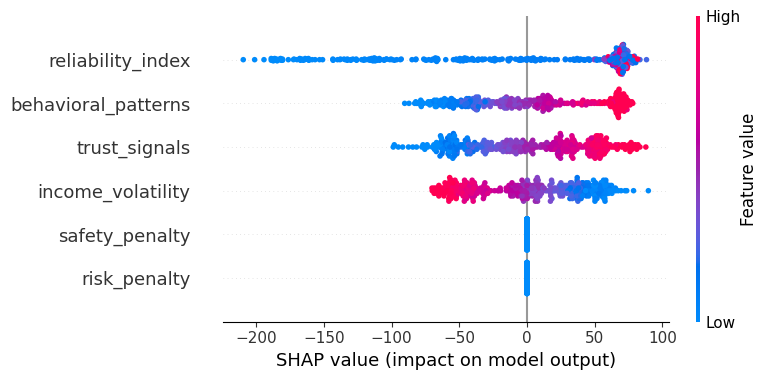

In [25]:

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# SHAP summary plot
shap.summary_plot(shap_values, X_test)


In [26]:

def improvement_tips(row: pd.Series) -> list:
    tips = []
    # Reliability
    if row.get("reliability_index", 1) < 0.9:
        tips.append("Increase on-time & acceptance; reduce cancellations to lift reliability.")
    # Trust
    if row.get("trust_signals", 1) < 0.6:
        tips.append("Boost repeat customers and average rating via consistent service quality.")
    # Behavior
    if row.get("behavioral_patterns", 1) < 0.5:
        tips.append("Improve consistency (more steady trips/hours).")
    # Safety & risk
    if row.get("safety_penalty", 0) > 0.5:
        tips.append("Reduce harsh brakes and speeding incidents.")
    if row.get("risk_penalty", 0) > 0.5:
        tips.append("Lower complaints and prevent chargebacks.")
    return tips

sample_idx = X_test.index[0]
print("Sample partner:", sample_idx)
display(df_feat.loc[[sample_idx], feature_cols + ["nova_score"]])
print("Suggested improvements:", improvement_tips(df_feat.loc[sample_idx]))


Sample partner: 1860


,reliability_index,trust_signals,behavioral_patterns,risk_penalty,safety_penalty,income_volatility,nova_score
1860,0.049231,0.685149,0.571429,0,0,0.179164,232.938797


Suggested improvements: ['Increase on-time & acceptance; reduce cancellations to lift reliability.']


In [27]:

# Choose a sensitive feature if present; otherwise simulate region from fallback
if "region" in df_feat.columns:
    sens = df_feat.loc[X_test.index, "region"]
elif "vehicle_type" in df_feat.columns:
    sens = df_feat.loc[X_test.index, "vehicle_type"]
else:
    np.random.seed(42)
    sens = pd.Series(np.random.choice(["North","South","East","West"], size=len(X_test)), index=X_test.index, name="region")

# Define RMSE metric for compatibility
def rmse_metric(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Group-wise error metrics for regression
mf = MetricFrame(
    metrics={
        "MAE": mean_absolute_error,
        "RMSE": rmse_metric
    },
    y_true=y_test, y_pred=y_pred,
    sensitive_features=sens
)
print("Fairness — Error by group")
display(mf.by_group)

# Convert to approval decision and check demographic parity difference
threshold = y_pred.mean()
approved_pred = (y_pred >= threshold).astype(int)

dpd = demographic_parity_difference(y_true=(y_test >= threshold).astype(int),
                                    y_pred=approved_pred,
                                    sensitive_features=sens)
print("Demographic Parity Difference (approval vs. mean threshold):", dpd)


Fairness — Error by group


,MAE,RMSE
region,,
East,33.027242,42.104362
North,31.997900,39.169736
South,35.812560,43.247598
West,34.297963,43.246686


Demographic Parity Difference (approval vs. mean threshold): 0.07704752275025284


In [28]:

# Bias mitigation using ThresholdOptimizer on the approval decision
# We train a simple logistic model on features to predict approval, then post-process for DP

# Prepare labels for classification
y_train_cls = (y_train >= y_pred.mean()).astype(int)  # policy threshold from earlier
y_test_cls = (y_test >= y_pred.mean()).astype(int)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train_cls)

raw_scores = clf.predict_proba(X_test)[:,1]

post = ThresholdOptimizer(estimator=clf, constraints="demographic_parity", predict_method="predict_proba")
# Ensure sensitive feature for training set matches fairness cell logic
if sens.name in df_feat.columns:
    sens_train = df_feat.loc[X_train.index, sens.name]
else:
    np.random.seed(42)
    sens_train = pd.Series(np.random.choice(["North","South","East","West"], size=len(X_train)), index=X_train.index, name="region")

post.fit(X_train, y_train_cls, sensitive_features=sens_train)

mitigated_pred_cls = post.predict(X_test, sensitive_features=sens)

# Compare selection rates by group before/after
mf_sel = MetricFrame(
    metrics={"selection_rate": selection_rate},
    y_true=y_test_cls,
    y_pred=pd.Series(approved_pred, index=X_test.index, name="approved_raw"),
    sensitive_features=sens
)
mf_sel_mitig = MetricFrame(
    metrics={"selection_rate": selection_rate},
    y_true=y_test_cls,
    y_pred=pd.Series(mitigated_pred_cls, index=X_test.index, name="approved_mitigated"),
    sensitive_features=sens
)

print("Selection rate by group — Raw")
display(mf_sel.by_group)
print("Selection rate by group — Mitigated (DP)")
display(mf_sel_mitig.by_group)


Selection rate by group — Raw


,selection_rate
region,
East,0.528846
North,0.536842
South,0.581395
West,0.504348


Selection rate by group — Mitigated (DP)


,selection_rate
region,
East,0.701923
North,0.621053
South,0.500000
West,0.513043


In [32]:
from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference, equalized_odds_difference
from sklearn.metrics import mean_absolute_error, mean_squared_error

def rmse_metric(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def generate_fairness_report(y_true, y_pred, sensitive_features, filename=None):
    """
    Generate a fairness report with error metrics and bias metrics.
    
    Args:
        y_true (array): Ground truth values
        y_pred (array): Predicted values (regression or binary classification)
        sensitive_features (Series): Sensitive attribute like region/vehicle_type
        filename (str, optional): If provided, saves the report as a text file
    """
    report = []
    report.append("=== Fairness Report ===\n")
    report.append(f"Sensitive feature: {sensitive_features.name}\n")
    report.append("-"*40 + "\n")
    
    # Error metrics by group
    mf = MetricFrame(
        metrics={
            "MAE": mean_absolute_error,
            "RMSE": rmse_metric
        },
        y_true=y_true,
        y_pred=y_pred,
        sensitive_features=sensitive_features
    )
    
    report.append("📊 Performance by Group:\n")
    report.append(str(mf.by_group))
    report.append("\n\n")
    
    # Threshold-based approval decision
    threshold = y_pred.mean()
    approved_true = (y_true >= threshold).astype(int)
    approved_pred = (y_pred >= threshold).astype(int)
    
    dpd = demographic_parity_difference(approved_true, approved_pred, sensitive_features=sensitive_features)
    eod = equalized_odds_difference(approved_true, approved_pred, sensitive_features=sensitive_features)
    
    report.append("⚖️ Fairness Metrics:\n")
    report.append(f"- Demographic Parity Difference: {dpd:.4f}\n")
    report.append(f"- Equalized Odds Difference: {eod:.4f}\n")
    report.append("\n\n")
    
    report.append("✅ Interpretation:\n")
    report.append("- MAE/RMSE by group shows predictive accuracy differences.\n")
    report.append("- Demographic Parity Difference near 0 → fair approval rates across groups.\n")
    report.append("- Equalized Odds Difference near 0 → equal error rates across groups.\n")
    
    final_report = "".join(report)
    
    print(final_report)
    
    # Save to file if requested
    if filename:
        with open(filename, "w", encoding="utf-8") as f:
            f.write(final_report)
        print(f"📁 Fairness report saved to {filename}")

# Example usage in notebook:
generate_fairness_report(y_test, y_pred, sensitive_features=sens, filename="fairness_report.txt")


=== Fairness Report ===
Sensitive feature: region
----------------------------------------
📊 Performance by Group:
              MAE       RMSE
region                      
East    33.027242  42.104362
North   31.997900  39.169736
South   35.812560  43.247598
West    34.297963  43.246686

⚖️ Fairness Metrics:
- Demographic Parity Difference: 0.0770
- Equalized Odds Difference: 0.1705


✅ Interpretation:
- MAE/RMSE by group shows predictive accuracy differences.
- Demographic Parity Difference near 0 → fair approval rates across groups.
- Equalized Odds Difference near 0 → equal error rates across groups.

📁 Fairness report saved to fairness_report.txt


In [35]:
%pip install reportlab

from reportlab.lib.pagesizes import A4
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle, Image
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib import colors
import matplotlib.pyplot as plt

def generate_fairness_report_pdf(y_true, y_pred, sensitive_features, pdf_path="fairness_report.pdf"):
    """
    Generate a detailed PDF fairness report for the AI model.
    
    Args:
        y_true (array): Ground truth values
        y_pred (array): Predicted values
        sensitive_features (Series): Sensitive attribute (e.g., region/vehicle_type)
        pdf_path (str): Path to save the PDF file
    """
    # --- Fairness Metrics ---
    import numpy as np
    mf = MetricFrame(
        metrics={
            "MAE": mean_absolute_error,
            "RMSE": lambda yt, yp: np.sqrt(mean_squared_error(yt, yp))
        },
        y_true=y_true,
        y_pred=y_pred,
        sensitive_features=sensitive_features
    )
    
    threshold = y_pred.mean()
    approved_true = (y_true >= threshold).astype(int)
    approved_pred = (y_pred >= threshold).astype(int)
    
    dpd = demographic_parity_difference(approved_true, approved_pred, sensitive_features=sensitive_features)
    eod = equalized_odds_difference(approved_true, approved_pred, sensitive_features=sensitive_features)
    
    # --- Create PDF Document ---
    doc = SimpleDocTemplate(pdf_path, pagesize=A4)
    styles = getSampleStyleSheet()
    story = []
    
    # Title
    story.append(Paragraph("Project Nova — Fairness Report", styles["Title"]))
    story.append(Spacer(1, 12))
    
    # Summary
    story.append(Paragraph("📘 This report evaluates the fairness of the Nova Credit Scoring Model.", styles["Normal"]))
    story.append(Spacer(1, 12))
    
    # Table: Performance by Group
    perf_data = [["Group", "MAE", "RMSE"]]
    for group, row in mf.by_group.iterrows():
        perf_data.append([group, f"{row['MAE']:.2f}", f"{row['RMSE']:.2f}"])
    
    table = Table(perf_data)
    table.setStyle(TableStyle([
        ("BACKGROUND", (0,0), (-1,0), colors.HexColor("#4F81BD")),
        ("TEXTCOLOR", (0,0), (-1,0), colors.white),
        ("ALIGN", (0,0), (-1,-1), "CENTER"),
        ("GRID", (0,0), (-1,-1), 0.5, colors.black),
        ("FONTNAME", (0,0), (-1,0), "Helvetica-Bold"),
    ]))
    
    story.append(Paragraph("📊 Model Performance by Group", styles["Heading2"]))
    story.append(table)
    story.append(Spacer(1, 20))
    
    # Fairness Metrics
    story.append(Paragraph("⚖️ Fairness Metrics", styles["Heading2"]))
    story.append(Paragraph(f"- Demographic Parity Difference: {dpd:.4f}", styles["Normal"]))
    story.append(Paragraph(f"- Equalized Odds Difference: {eod:.4f}", styles["Normal"]))
    story.append(Spacer(1, 20))
    
    # Interpretation Notes
    story.append(Paragraph("✅ Interpretation", styles["Heading2"]))
    story.append(Paragraph(
        "- MAE/RMSE by group show predictive accuracy differences.<br/>"
        "- Demographic Parity Difference near 0 → approvals fairly distributed.<br/>"
        "- Equalized Odds Difference near 0 → errors fairly distributed.<br/>"
        "- Larger differences → potential fairness concerns requiring mitigation.",
        styles["Normal"]
    ))
    story.append(Spacer(1, 20))
    
    # --- Add Visualization (Bar Chart) ---
    plt.figure(figsize=(5,3))
    mf.by_group["MAE"].plot(kind="bar", title="MAE by Group")
    plt.ylabel("MAE")
    plt.tight_layout()
    chart_path = "mae_by_group.png"
    plt.savefig(chart_path)
    plt.close()
    
    story.append(Paragraph("📈 MAE by Group", styles["Heading2"]))
    story.append(Image(chart_path, width=400, height=250))
    
    # Build PDF
    doc.build(story)
    print(f"📁 Fairness report PDF saved to {pdf_path}")
    

# Example usage
generate_fairness_report_pdf(y_test, y_pred, sensitive_features=sens, pdf_path="fairness_report.pdf")


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
📁 Fairness report PDF saved to fairness_report.pdf



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [50]:
from reportlab.lib.pagesizes import A4
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle, PageBreak, LongTable, Image
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib import colors
from reportlab.lib.units import inch
import matplotlib
matplotlib.use("Agg")  # headless backend
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import os
import warnings

# ------------------- Utility functions -------------------
def _add_page_number(canvas, doc):
    canvas.saveState()
    canvas.setFont('Helvetica', 8)
    canvas.drawString(inch*0.5, 0.5*inch, f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    canvas.drawRightString(A4[0]-inch*0.5, 0.5*inch, f"Page {doc.page}")
    canvas.restoreState()

def _generate_tips(row):
    tips = []
    if "on_time_rate" in row.index and row["on_time_rate"] < 0.9:
        tips.append("Increase on-time rate.")
    if "acceptance_rate" in row.index and row["acceptance_rate"] < 0.8:
        tips.append("Improve acceptance rate.")
    if "rating_avg" in row.index and row["rating_avg"] < 4.2:
        tips.append("Improve average rating.")
    if "repeat_customers" in row.index and row["repeat_customers"] < 10:
        tips.append("Encourage repeat customers.")
    if "cancelled_jobs" in row.index and row["cancelled_jobs"] > 5:
        tips.append("Reduce cancellations.")
    if "income_volatility" in row.index and row["income_volatility"] > 0.4:
        tips.append("Stabilize income/earnings.")
    if not tips:
        tips.append("Maintain performance.")
    return " ; ".join(tips[:3])

# ------------------- Main PDF generator -------------------
def generate_score_report(df_full, y_pred, approval_top_pct=60, user_id_col="partner_id", pdf_path="score_report.pdf"):
    os.makedirs("report_images", exist_ok=True)
    
    df = df_full.copy()
    df["predicted_score"] = y_pred
    cutoff = np.percentile(y_pred, 100 - approval_top_pct)
    df["eligible"] = (df["predicted_score"] >= cutoff).astype(int)
    df["tips"] = df.apply(_generate_tips, axis=1)
    
    # Histogram
    plt.figure(figsize=(6,3))
    plt.hist(df["predicted_score"], bins=30, edgecolor="black")
    plt.axvline(cutoff, color="red", linestyle="--", label=f"Eligibility cutoff = {cutoff:.0f}")
    plt.title("Predicted Score Distribution")
    plt.xlabel("Score")
    plt.ylabel("Count")
    plt.legend()
    hist_path = "report_images/score_hist.png"
    plt.tight_layout()
    plt.savefig(hist_path, dpi=150)
    plt.close()
    
    # Top & Bottom performers (5 each)
    top_df = df[df["eligible"]==1].nlargest(5, "predicted_score")
    bottom_df = df[df["eligible"]==0].nsmallest(5, "predicted_score")
    
    # Build PDF
    doc = SimpleDocTemplate(pdf_path, pagesize=A4, rightMargin=40,leftMargin=40, topMargin=60,bottomMargin=60)
    styles = getSampleStyleSheet()
    normal = styles["Normal"]
    h1 = styles["Title"]
    h2 = styles["Heading2"]
    
    story = []
    
    story.append(Paragraph("AI Credit Score & Eligibility Report", h1))
    story.append(Spacer(1,12))
    story.append(Paragraph(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}", normal))
    story.append(Spacer(1,12))
    story.append(Paragraph(f"- Eligibility cutoff (top {approval_top_pct}%): {cutoff:.0f}", normal))
    story.append(Spacer(1,12))
    
    # Histogram
    story.append(Paragraph("Score Distribution", h2))
    story.append(Image(hist_path, width=450, height=200))
    story.append(Spacer(1,12))
    
    # Table of top performers
    if not top_df.empty:
        story.append(Paragraph("Top Eligible Users", h2))
        cols = ["partner_id","predicted_score","eligible","tips"]
        table_data = [cols] + top_df[cols].astype(str).values.tolist()
        t = LongTable(table_data, repeatRows=1)
        t.setStyle(TableStyle([
            ("GRID",(0,0),(-1,-1),0.25,colors.grey),
            ("BACKGROUND",(0,0),(-1,0),colors.HexColor("#9BBB59")),
            ("TEXTCOLOR",(0,0),(-1,0),colors.white),
            ("FONTNAME",(0,0),(-1,0),"Helvetica-Bold")
        ]))
        story.append(t)
    
    # Table of bottom performers (if any)
    if not bottom_df.empty:
        story.append(Spacer(1,12))
        story.append(Paragraph("Bottom Non-Eligible Users", h2))
        cols = ["partner_id","predicted_score","eligible","tips"]
        table_data = [cols] + bottom_df[cols].astype(str).values.tolist()
        t2 = LongTable(table_data, repeatRows=1)
        t2.setStyle(TableStyle([
            ("GRID",(0,0),(-1,-1),0.25,colors.grey),
            ("BACKGROUND",(0,0),(-1,0),colors.HexColor("#D9534F")),
            ("TEXTCOLOR",(0,0),(-1,0),colors.white),
            ("FONTNAME",(0,0),(-1,0),"Helvetica-Bold")
        ]))
        story.append(t2)
    
    # Footer notes
    story.append(Spacer(1,12))
    story.append(Paragraph("Notes:", h2))
    story.append(Paragraph("- This report shows predicted score and eligibility as calculated by the model.", normal))
    story.append(Paragraph("- Improvement tips are suggested actions to increase score.", normal))
    story.append(Paragraph("- Only top/bottom users are displayed for clarity.", normal))
    
    doc.build(story, onFirstPage=_add_page_number, onLaterPages=_add_page_number)
    print(f"✅ PDF generated: {pdf_path}")

# ------------------- Example usage -------------------
if __name__=="__main__":
    # Dummy data
    n = 30
    df = pd.DataFrame({
        "partner_id": np.arange(1,n+1),
        "on_time_rate": np.random.rand(n),
        "acceptance_rate": np.random.rand(n),
        "rating_avg": np.random.rand(n)*5,
        "repeat_customers": np.random.randint(0,20,n),
        "cancelled_jobs": np.random.randint(0,10,n),
        "income_volatility": np.random.rand(n)
    })
    y_pred = np.random.randint(50,100,n)
    
    generate_score_report(df, y_pred, approval_top_pct=60, user_id_col="partner_id", pdf_path="final_score_report.pdf")


✅ PDF generated: final_score_report.pdf
